In [1]:
# Cell 1: Imports & Basic Config

import os
import glob
import cv2
import math
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

from torchvision import transforms

from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Super-resolution scale factor
UPSCALE_FACTOR = 2  # you can change to 4 if you want


Device: cuda


In [2]:
# Cell 2: Utility Functions (PSNR, SSIM, Tensor <-> Image)

def tensor_to_image(tensor):
    """Convert torch tensor (1, C, H, W) or (C, H, W) in [0,1] to uint8 RGB image."""
    if tensor.dim() == 4:
        tensor = tensor[0]
    img = tensor.detach().cpu().clamp(0, 1).numpy()
    img = np.transpose(img, (1, 2, 0))  # CHW -> HWC
    img = (img * 255.0).round().astype(np.uint8)
    return img

def image_to_tensor(img):
    """Convert HWC uint8 RGB to torch tensor (C, H, W) in [0,1]."""
    img = img.astype(np.float32) / 255.0
    img = np.transpose(img, (2, 0, 1))  # HWC -> CHW
    return torch.from_numpy(img)

def psnr_tensors(sr, hr):
    sr_img = tensor_to_image(sr)
    hr_img = tensor_to_image(hr)
    return compare_psnr(hr_img, sr_img, data_range=255)

def ssim_tensors(sr, hr):
    sr_img = tensor_to_image(sr)
    hr_img = tensor_to_image(hr)
    return compare_ssim(hr_img, sr_img, data_range=255, channel_axis=2)


In [3]:
# Cell 3: Super-Resolution Dataset (HR -> LR, Bicubic, HR)

class SRDataset(Dataset):
    """
    Returns:
      bicubic: (for SRCNN input)   - HR size
      lr:       (for ESPCN input)  - LR size
      hr:       ground truth HR    - HR size
    """
    def __init__(self, hr_dir, upscale_factor=2, patch_size=128, augment=True):
        self.hr_paths = sorted(
            glob.glob(os.path.join(hr_dir, "*.png")) +
            glob.glob(os.path.join(hr_dir, "*.jpg")) +
            glob.glob(os.path.join(hr_dir, "*.jpeg"))
        )
        self.upscale = upscale_factor
        self.patch_size = patch_size
        self.augment = augment

    def __len__(self):
        return len(self.hr_paths)

    def __getitem__(self, idx):
        path = self.hr_paths[idx]
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        h, w, _ = img.shape

        if self.patch_size is not None:
            ps = self.patch_size
            # ensure divisible by upscale
            ps = ps - (ps % self.upscale)
            if h < ps or w < ps:
                img = cv2.resize(img, (max(ps, w), max(ps, h)), interpolation=cv2.INTER_CUBIC)
                h, w, _ = img.shape
            y = np.random.randint(0, h - ps + 1)
            x = np.random.randint(0, w - ps + 1)
            img = img[y:y+ps, x:x+ps, :]
        else:
            # center crop to multiple of upscale
            h_new = h - (h % self.upscale)
            w_new = w - (w % self.upscale)
            y = (h - h_new) // 2
            x = (w - w_new) // 2
            img = img[y:y+h_new, x:x+w_new, :]

        hr = img
        # create LR by downscaling
        lr_h = hr.shape[0] // self.upscale
        lr_w = hr.shape[1] // self.upscale
        lr = cv2.resize(hr, (lr_w, lr_h), interpolation=cv2.INTER_AREA)
        # bicubic upsample back to HR size (SRCNN input)
        bicubic = cv2.resize(lr, (hr.shape[1], hr.shape[0]), interpolation=cv2.INTER_CUBIC)

        if self.augment:
            if np.random.rand() < 0.5:
                hr = np.fliplr(hr)
                lr = np.fliplr(lr)
                bicubic = np.fliplr(bicubic)
            if np.random.rand() < 0.5:
                hr = np.flipud(hr)
                lr = np.flipud(lr)
                bicubic = np.flipud(bicubic)

        hr_t = image_to_tensor(hr)
        lr_t = image_to_tensor(lr)
        bicubic_t = image_to_tensor(bicubic)

        return bicubic_t, lr_t, hr_t

# ---- Set your HR dataset paths here ----
TRAIN_HR_DIR = "/home/akif/ASG15/DIV2K_train_HR/DIV2K_train_HR"  # TODO: put your actual path
VAL_HR_DIR   = "/home/akif/ASG15/DIV2K_valid_HR/DIV2K_valid_HR"    # TODO: put your actual path

train_dataset = SRDataset(TRAIN_HR_DIR, upscale_factor=UPSCALE_FACTOR, patch_size=384, augment=True)
val_dataset   = SRDataset(VAL_HR_DIR,   upscale_factor=UPSCALE_FACTOR, patch_size=384, augment=False)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

print("Train images:", len(train_dataset))
print("Val images:", len(val_dataset))


Train images: 800
Val images: 100


In [4]:
# Cell 4: Define SRCNN Model

class SRCNN(nn.Module):
    """
    Simple 3-layer SRCNN operating on RGB.
    Input: bicubic-upsampled HR-size image.
    Output: refined HR-size image.
    """
    def __init__(self):
        super(SRCNN, self).__init__()
        self.layer1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.layer2 = nn.Conv2d(64, 32, kernel_size=5, padding=2)
        self.layer3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

srcnn = SRCNN().to(device)
print(srcnn)


SRCNN(
  (layer1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (layer2): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (layer3): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU(inplace=True)
)


In [5]:
# Cell 5: Define ESPCN Model (Sub-pixel Convolution)

class ESPCN(nn.Module):
    """
    ESPCN with sub-pixel convolution for upscaling.
    Input: LR image.
    Output: HR image (upscale factor).
    """
    def __init__(self, upscale_factor=2):
        super(ESPCN, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, padding=2),
            nn.Tanh(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.Conv2d(32, 3 * (upscale_factor ** 2), kernel_size=3, padding=1)
        )
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.pixel_shuffle(x)
        return x

espcn = ESPCN(upscale_factor=UPSCALE_FACTOR).to(device)
print(espcn)


ESPCN(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Tanh()
    (4): Conv2d(32, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (pixel_shuffle): PixelShuffle(upscale_factor=2)
)


In [6]:
# Cell 6: Generic Training & Validation Loop

def train_one_epoch(model, optimizer, train_loader, criterion, model_type="srcnn"):
    model.train()
    total_loss = 0.0
    for bicubic, lr, hr in train_loader:
        bicubic = bicubic.to(device)
        lr = lr.to(device)
        hr = hr.to(device)

        optimizer.zero_grad()

        if model_type.lower() == "srcnn":
            sr = model(bicubic)
        else:  # espcn
            sr = model(lr)

        loss = criterion(sr, hr)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * hr.size(0)

    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def validate(model, val_loader, criterion, model_type="srcnn"):
    model.eval()
    total_loss = 0.0
    total_psnr = 0.0

    for bicubic, lr, hr in val_loader:
        bicubic = bicubic.to(device)
        lr = lr.to(device)
        hr = hr.to(device)

        if model_type.lower() == "srcnn":
            sr = model(bicubic)
        else:
            sr = model(lr)

        loss = criterion(sr, hr)
        total_loss += loss.item() * hr.size(0)

        # compute PSNR on batch (average)
        for i in range(hr.size(0)):
            psnr = psnr_tensors(sr[i], hr[i])
            total_psnr += psnr

    avg_loss = total_loss / len(val_loader.dataset)
    avg_psnr = total_psnr / len(val_loader.dataset)

    return avg_loss, avg_psnr


In [7]:
# Cell 7: Train SRCNN

num_epochs_srcnn = 100  # adjust as you like
criterion = nn.MSELoss()

srcnn = SRCNN().to(device)
optimizer_srcnn = Adam(srcnn.parameters(), lr=1e-4)

best_psnr_srcnn = 0.0

for epoch in range(1, num_epochs_srcnn + 1):
    train_loss = train_one_epoch(srcnn, optimizer_srcnn, train_loader, criterion, model_type="srcnn")
    val_loss, val_psnr = validate(srcnn, val_loader, criterion, model_type="srcnn")

    if val_psnr > best_psnr_srcnn:
        best_psnr_srcnn = val_psnr
        torch.save(srcnn.state_dict(), "best_srcnn.pth")

    print(f"[SRCNN] Epoch {epoch}/{num_epochs_srcnn} | Train Loss: {train_loss:.4f} "
          f"| Val Loss: {val_loss:.4f} | Val PSNR: {val_psnr:.2f} dB")

print("Best SRCNN PSNR:", best_psnr_srcnn)


[SRCNN] Epoch 1/100 | Train Loss: 0.1962 | Val Loss: 0.0762 | Val PSNR: 12.15 dB
[SRCNN] Epoch 2/100 | Train Loss: 0.0394 | Val Loss: 0.0239 | Val PSNR: 17.09 dB
[SRCNN] Epoch 3/100 | Train Loss: 0.0206 | Val Loss: 0.0163 | Val PSNR: 18.65 dB
[SRCNN] Epoch 4/100 | Train Loss: 0.0145 | Val Loss: 0.0105 | Val PSNR: 20.69 dB
[SRCNN] Epoch 5/100 | Train Loss: 0.0102 | Val Loss: 0.0078 | Val PSNR: 22.12 dB
[SRCNN] Epoch 6/100 | Train Loss: 0.0072 | Val Loss: 0.0062 | Val PSNR: 23.10 dB
[SRCNN] Epoch 7/100 | Train Loss: 0.0056 | Val Loss: 0.0053 | Val PSNR: 24.03 dB
[SRCNN] Epoch 8/100 | Train Loss: 0.0047 | Val Loss: 0.0043 | Val PSNR: 24.94 dB
[SRCNN] Epoch 9/100 | Train Loss: 0.0043 | Val Loss: 0.0038 | Val PSNR: 25.73 dB
[SRCNN] Epoch 10/100 | Train Loss: 0.0038 | Val Loss: 0.0034 | Val PSNR: 25.79 dB
[SRCNN] Epoch 11/100 | Train Loss: 0.0034 | Val Loss: 0.0031 | Val PSNR: 26.50 dB
[SRCNN] Epoch 12/100 | Train Loss: 0.0031 | Val Loss: 0.0027 | Val PSNR: 27.38 dB
[SRCNN] Epoch 13/100 | Tr

In [8]:
# Cell 8: Train ESPCN

num_epochs_espcn = 100  # adjust
criterion = nn.MSELoss()

espcn = ESPCN(upscale_factor=UPSCALE_FACTOR).to(device)
optimizer_espcn = Adam(espcn.parameters(), lr=1e-4)

best_psnr_espcn = 0.0

for epoch in range(1, num_epochs_espcn + 1):
    train_loss = train_one_epoch(espcn, optimizer_espcn, train_loader, criterion, model_type="espcn")
    val_loss, val_psnr = validate(espcn, val_loader, criterion, model_type="espcn")

    if val_psnr > best_psnr_espcn:
        best_psnr_espcn = val_psnr
        torch.save(espcn.state_dict(), "best_espcn.pth")

    print(f"[ESPCN] Epoch {epoch}/{num_epochs_espcn} | Train Loss: {train_loss:.4f} "
          f"| Val Loss: {val_loss:.4f} | Val PSNR: {val_psnr:.2f} dB")

print("Best ESPCN PSNR:", best_psnr_espcn)


[ESPCN] Epoch 1/100 | Train Loss: 0.1528 | Val Loss: 0.0732 | Val PSNR: 12.70 dB
[ESPCN] Epoch 2/100 | Train Loss: 0.0478 | Val Loss: 0.0281 | Val PSNR: 16.02 dB
[ESPCN] Epoch 3/100 | Train Loss: 0.0247 | Val Loss: 0.0197 | Val PSNR: 17.56 dB
[ESPCN] Epoch 4/100 | Train Loss: 0.0203 | Val Loss: 0.0184 | Val PSNR: 17.98 dB
[ESPCN] Epoch 5/100 | Train Loss: 0.0179 | Val Loss: 0.0166 | Val PSNR: 18.43 dB
[ESPCN] Epoch 6/100 | Train Loss: 0.0158 | Val Loss: 0.0156 | Val PSNR: 18.92 dB
[ESPCN] Epoch 7/100 | Train Loss: 0.0149 | Val Loss: 0.0140 | Val PSNR: 19.26 dB
[ESPCN] Epoch 8/100 | Train Loss: 0.0135 | Val Loss: 0.0134 | Val PSNR: 19.51 dB
[ESPCN] Epoch 9/100 | Train Loss: 0.0125 | Val Loss: 0.0114 | Val PSNR: 20.20 dB
[ESPCN] Epoch 10/100 | Train Loss: 0.0118 | Val Loss: 0.0108 | Val PSNR: 20.53 dB
[ESPCN] Epoch 11/100 | Train Loss: 0.0112 | Val Loss: 0.0113 | Val PSNR: 20.53 dB
[ESPCN] Epoch 12/100 | Train Loss: 0.0105 | Val Loss: 0.0100 | Val PSNR: 21.00 dB
[ESPCN] Epoch 13/100 | Tr

In [9]:
# Cell 9: Load Best Models (for testing/inference)

srcnn = SRCNN().to(device)
espcn = ESPCN(upscale_factor=UPSCALE_FACTOR).to(device)

if os.path.exists("best_srcnn.pth"):
    srcnn.load_state_dict(torch.load("best_srcnn.pth", map_location=device))
if os.path.exists("best_espcn.pth"):
    espcn.load_state_dict(torch.load("best_espcn.pth", map_location=device))

srcnn.eval()
espcn.eval()
print("Loaded best SRCNN and ESPCN models.")


Loaded best SRCNN and ESPCN models.


In [10]:
# Cell 10: Testing on Validation Set (Quantitative Comparison)

@torch.no_grad()
def evaluate_model(model, data_loader, model_type="srcnn"):
    model.eval()
    total_psnr = 0.0
    total_ssim = 0.0
    count = 0

    for bicubic, lr, hr in data_loader:
        bicubic = bicubic.to(device)
        lr = lr.to(device)
        hr = hr.to(device)

        if model_type.lower() == "srcnn":
            sr = model(bicubic)
        else:
            sr = model(lr)

        for i in range(hr.size(0)):
            psnr = psnr_tensors(sr[i], hr[i])
            ssim = ssim_tensors(sr[i], hr[i])
            total_psnr += psnr
            total_ssim += ssim
            count += 1

    return total_psnr / count, total_ssim / count


srcnn_psnr, srcnn_ssim = evaluate_model(srcnn, val_loader, model_type="srcnn")
espcn_psnr, espcn_ssim = evaluate_model(espcn, val_loader, model_type="espcn")

print(f"SRCNN  -> PSNR: {srcnn_psnr:.2f} dB, SSIM: {srcnn_ssim:.4f}")
print(f"ESPCN  -> PSNR: {espcn_psnr:.2f} dB, SSIM: {espcn_ssim:.4f}")


SRCNN  -> PSNR: 31.06 dB, SSIM: 0.8957
ESPCN  -> PSNR: 28.17 dB, SSIM: 0.8428


In [11]:
# Cell 11: Super-Resolve Your Phone LR Images with SRCNN & ESPCN

phone_lr_dir = "/home/akif/ASG15/akif_photos_LR"
output_dir = "/home/akif/ASG15/phone_results"
os.makedirs(output_dir, exist_ok=True)

@torch.no_grad()
def sr_on_phone_images():
    for path in sorted(glob.glob(os.path.join(phone_lr_dir, "*.png"))):
        filename = os.path.basename(path)
        name = os.path.splitext(filename)[0]

        # read LR phone image
        lr_bgr = cv2.imread(path)
        lr_rgb = cv2.cvtColor(lr_bgr, cv2.COLOR_BGR2RGB)

        h, w, _ = lr_rgb.shape
        hr_h = h * UPSCALE_FACTOR
        hr_w = w * UPSCALE_FACTOR

        # bicubic baseline
        bicubic_rgb = cv2.resize(lr_rgb, (hr_w, hr_h), interpolation=cv2.INTER_CUBIC)

        # Prepare tensors
        lr_t = image_to_tensor(lr_rgb).unsqueeze(0).to(device)
        bicubic_t = image_to_tensor(bicubic_rgb).unsqueeze(0).to(device)

        # SRCNN (takes bicubic)
        sr_srcnn_t = srcnn(bicubic_t)
        sr_srcnn = tensor_to_image(sr_srcnn_t)

        # ESPCN (takes LR)
        sr_espcn_t = espcn(lr_t)
        sr_espcn = tensor_to_image(sr_espcn_t)

        # Save all
        bicubic_out = Image.fromarray(bicubic_rgb)
        srcnn_out   = Image.fromarray(sr_srcnn)
        espcn_out   = Image.fromarray(sr_espcn)

        bicubic_out.save(os.path.join(output_dir, f"{name}_x{UPSCALE_FACTOR}_bicubic.png"))
        srcnn_out.save(os.path.join(output_dir, f"{name}_x{UPSCALE_FACTOR}_srcnn.png"))
        espcn_out.save(os.path.join(output_dir, f"{name}_x{UPSCALE_FACTOR}_espcn.png"))

        print("Processed:", filename)

sr_on_phone_images()
print("Saved results to:", output_dir)


Processed: LR_akif_phone_image_1.png
Processed: LR_akif_phone_image_2.png
Processed: LR_akif_phone_image_3.png
Processed: LR_akif_phone_image_5.png
Processed: LR_akif_phone_image_6.png
Processed: LR_akif_phone_image_7.png
Processed: LR_akif_phone_image_8.png
Processed: LR_akif_phone_image_9.png
Processed: LR_input_bus.png
Saved results to: /home/akif/ASG15/phone_results


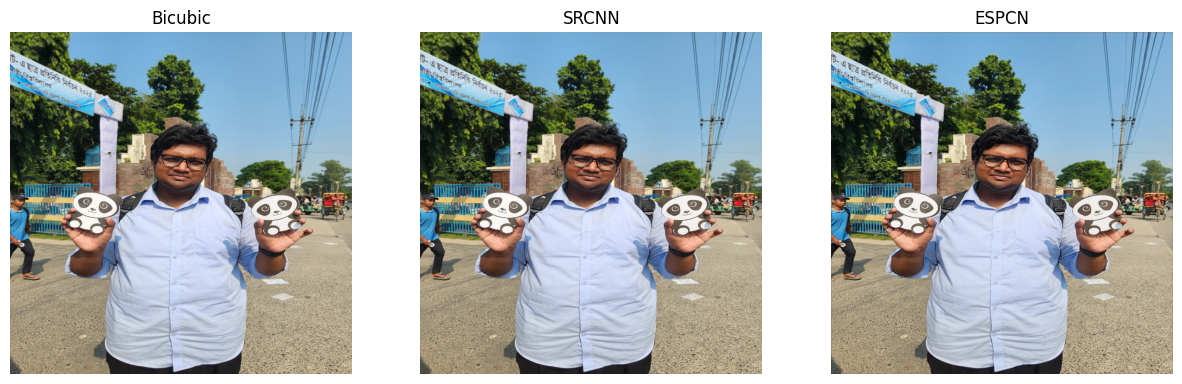

In [ ]:
# Cell 12: Quick Visual Check of One Example (Notebook Display)

import matplotlib.pyplot as plt

example_name = None  # set to a base filename if you want; else auto-pick

result_files = sorted(glob.glob(os.path.join(output_dir, "*_bicubic.png")))
if not result_files:
    print("No result images found in:", output_dir)
else:
    if example_name is None:
        sample_path = result_files[0]
        base = os.path.basename(sample_path).replace("_bicubic.png", "")
    else:
        base = example_name

    bicubic_path = os.path.join(output_dir, f"{base}_bicubic.png".replace(f"_x{UPSCALE_FACTOR}", f"_x{UPSCALE_FACTOR}"))
    srcnn_path   = os.path.join(output_dir, f"{base}_srcnn.png".replace(f"_x{UPSCALE_FACTOR}", f"_x{UPSCALE_FACTOR}"))
    espcn_path   = os.path.join(output_dir, f"{base}_espcn.png".replace(f"_x{UPSCALE_FACTOR}", f"_x{UPSCALE_FACTOR}"))

    bicubic = cv2.cvtColor(cv2.imread(bicubic_path), cv2.COLOR_BGR2RGB)
    srcnn_i = cv2.cvtColor(cv2.imread(srcnn_path), cv2.COLOR_BGR2RGB)
    espcn_i = cv2.cvtColor(cv2.imread(espcn_path), cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1); plt.imshow(bicubic); plt.title("Bicubic"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(srcnn_i); plt.title("SRCNN"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(espcn_i); plt.title("ESPCN"); plt.axis("off")
    plt.show()


Found 9 phone test images. Evaluating all...
akif_phone_image_1: PSNR Bicubic=32.46 dB, SRCNN=31.14 dB, ESPCN=30.27 dB


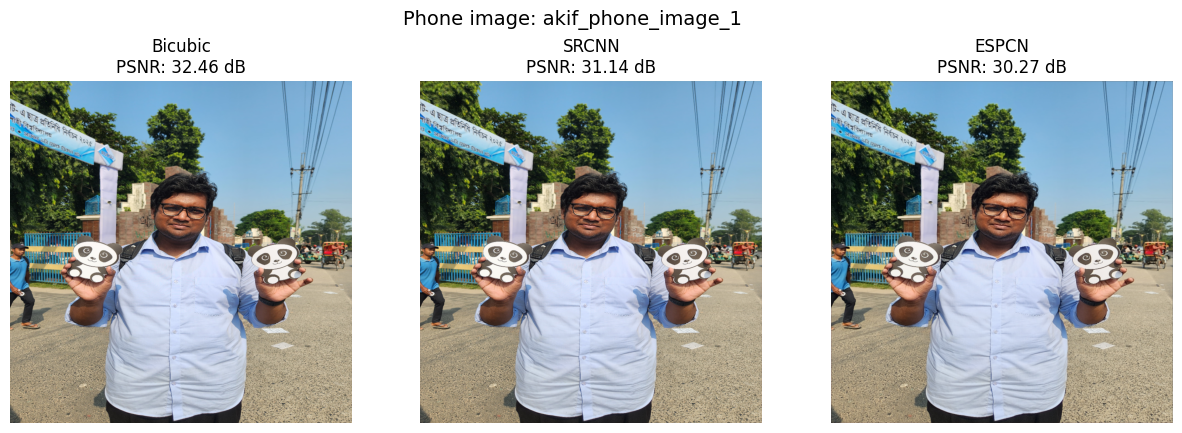

akif_phone_image_2: PSNR Bicubic=43.88 dB, SRCNN=42.39 dB, ESPCN=34.51 dB


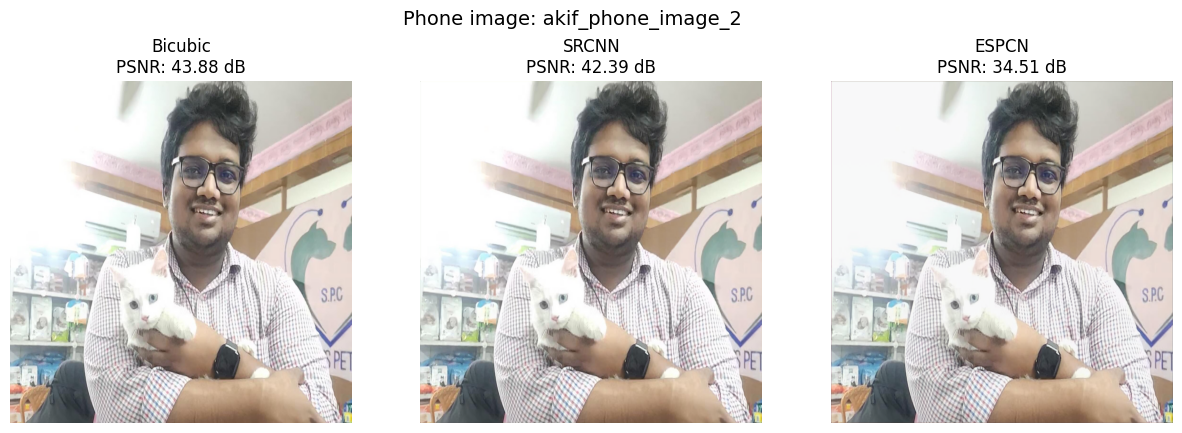

akif_phone_image_3: PSNR Bicubic=39.38 dB, SRCNN=38.08 dB, ESPCN=35.95 dB


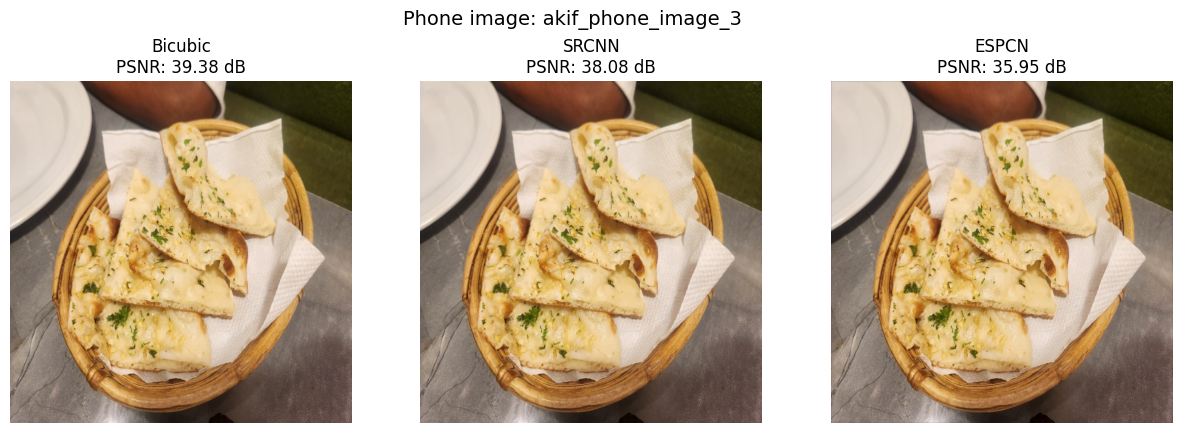

akif_phone_image_5: PSNR Bicubic=39.56 dB, SRCNN=38.05 dB, ESPCN=34.86 dB


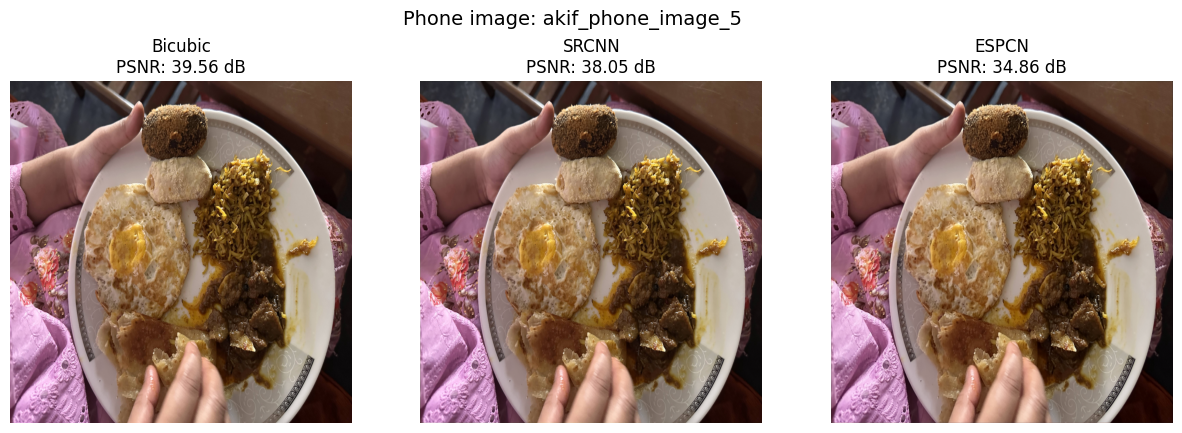

akif_phone_image_6: PSNR Bicubic=42.42 dB, SRCNN=39.70 dB, ESPCN=35.43 dB


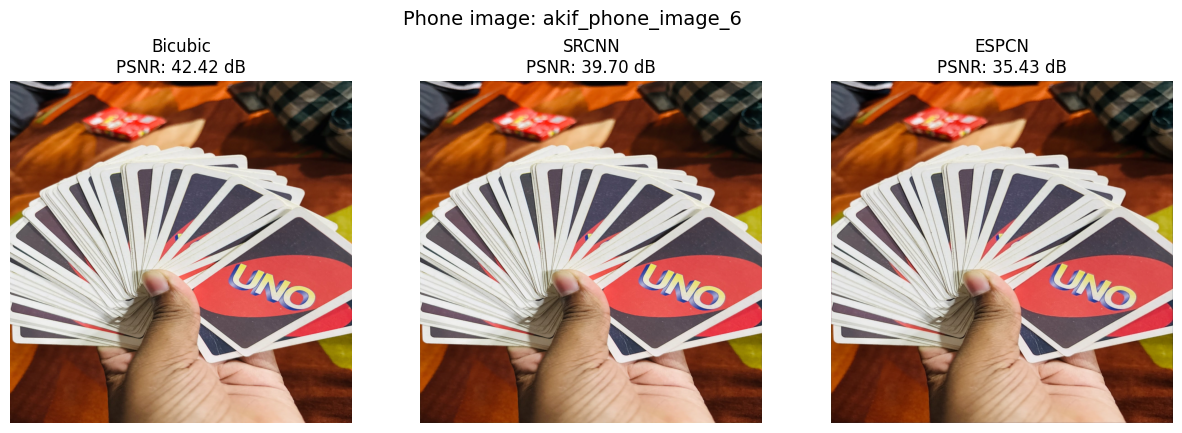

akif_phone_image_7: PSNR Bicubic=34.65 dB, SRCNN=33.26 dB, ESPCN=31.28 dB


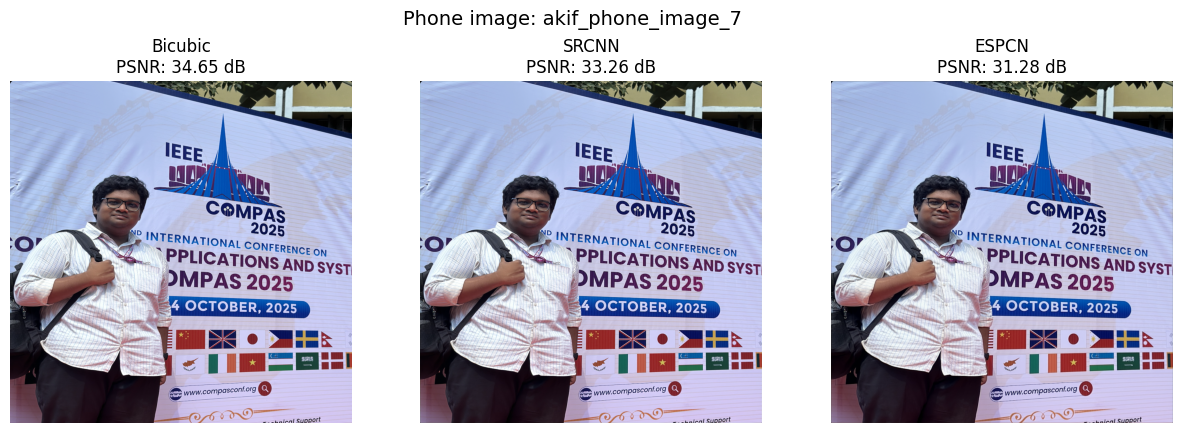

akif_phone_image_8: PSNR Bicubic=38.11 dB, SRCNN=36.98 dB, ESPCN=34.16 dB


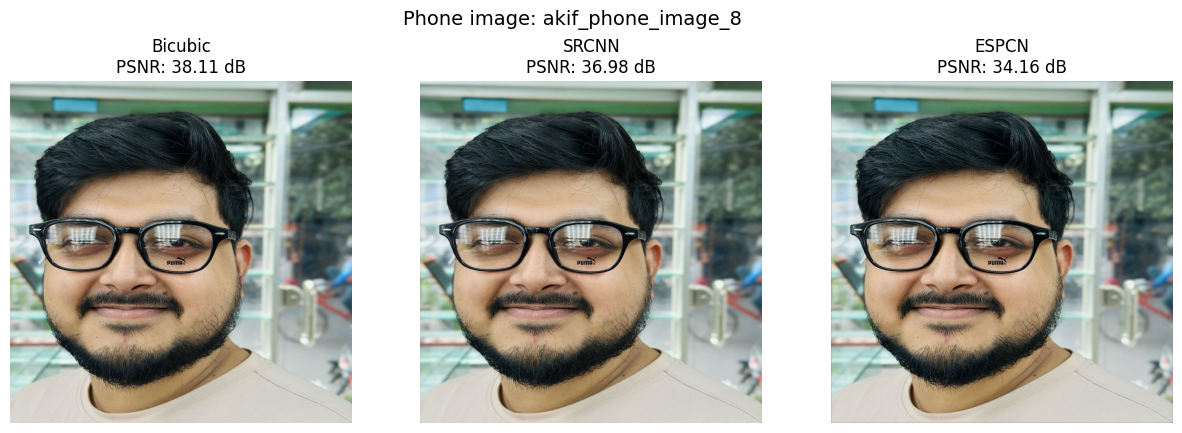

akif_phone_image_9: PSNR Bicubic=31.85 dB, SRCNN=30.59 dB, ESPCN=29.41 dB


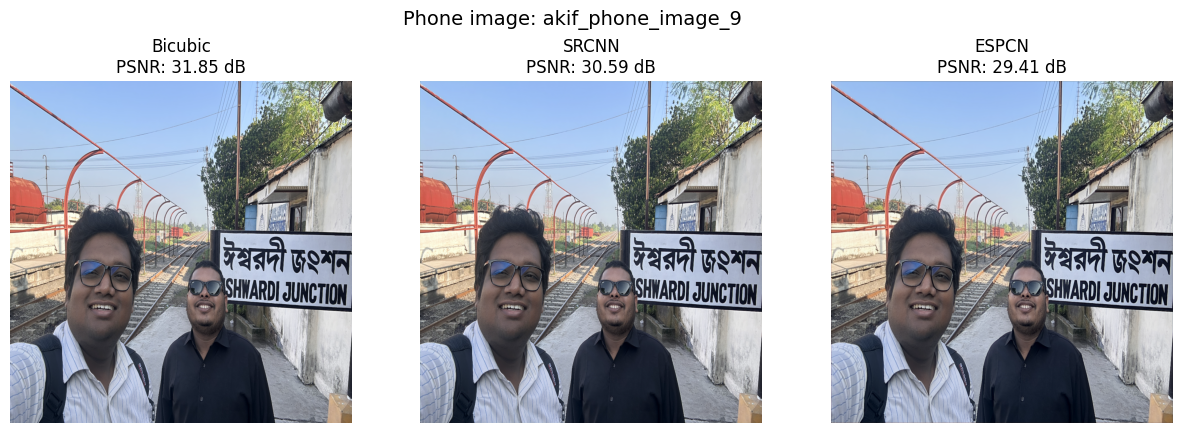

input_bus: PSNR Bicubic=39.22 dB, SRCNN=38.01 dB, ESPCN=34.79 dB


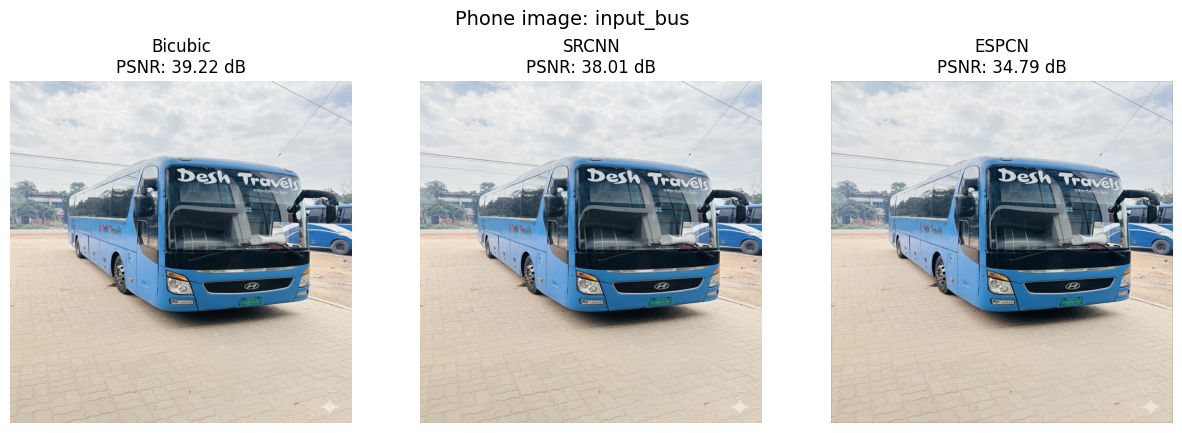

In [14]:
# Cell 12: Visual + PSNR Evaluation for ALL Phone Images

import matplotlib.pyplot as plt
import os
import glob
from skimage.metrics import peak_signal_noise_ratio as compare_psnr

# Folder containing original HR phone images (before making LR)
phone_hr_dir = "/home/akif/ASG15/akif_photos"

# Find all bicubic result images
bicubic_files = sorted(glob.glob(os.path.join(output_dir, f"*_x{UPSCALE_FACTOR}_bicubic.png")))

if not bicubic_files:
    print("No result images found in:", output_dir)
else:
    print(f"Found {len(bicubic_files)} phone test images. Evaluating all...")

    for bicubic_path in bicubic_files:
        # base name without suffix, e.g. "LR_photo1_x2"
        base = os.path.basename(bicubic_path).replace("_bicubic.png", "")

        # matching file paths
        srcnn_path = os.path.join(output_dir, f"{base}_srcnn.png")
        espcn_path = os.path.join(output_dir, f"{base}_espcn.png")

        if not (os.path.exists(srcnn_path) and os.path.exists(espcn_path)):
            print("Skipping (missing SR files):", base)
            continue

        # read SR outputs
        bicubic = cv2.cvtColor(cv2.imread(bicubic_path), cv2.COLOR_BGR2RGB)
        srcnn_i = cv2.cvtColor(cv2.imread(srcnn_path), cv2.COLOR_BGR2RGB)
        espcn_i = cv2.cvtColor(cv2.imread(espcn_path), cv2.COLOR_BGR2RGB)

        # derive original HR filename (strip _x2 and LR_ prefix)
        orig_name = base.replace(f"_x{UPSCALE_FACTOR}", "")   # e.g. "LR_photo1"
        hr_stem = orig_name[3:] if orig_name.startswith("LR_") else orig_name

        # try different extensions to find HR file
        hr_path = None
        for ext in [".png", ".jpg", ".jpeg", ".JPG", ".JPEG"]:
            candidate = os.path.join(phone_hr_dir, hr_stem + ext)
            if os.path.exists(candidate):
                hr_path = candidate
                break

        if hr_path is None:
            print(f"[WARN] No HR file found for: {hr_stem}. PSNR skipped.")
            continue

        # read HR phone image
        hr_bgr = cv2.imread(hr_path)
        hr_rgb = cv2.cvtColor(hr_bgr, cv2.COLOR_BGR2RGB)

        # resize HR to match SR output size
        target_h, target_w = srcnn_i.shape[:2]
        hr_resized = cv2.resize(hr_rgb, (target_w, target_h), interpolation=cv2.INTER_AREA)

        # compute PSNR values
        psnr_bicubic = compare_psnr(hr_resized, bicubic, data_range=255)
        psnr_srcnn   = compare_psnr(hr_resized, srcnn_i, data_range=255)
        psnr_espcn   = compare_psnr(hr_resized, espcn_i, data_range=255)

        print(
            f"{hr_stem}: "
            f"PSNR Bicubic={psnr_bicubic:.2f} dB, "
            f"SRCNN={psnr_srcnn:.2f} dB, "
            f"ESPCN={psnr_espcn:.2f} dB"
        )

        # show side-by-side with PSNR in titles
        plt.figure(figsize=(15, 5))
        plt.suptitle(f"Phone image: {hr_stem}", fontsize=14)

        plt.subplot(1, 3, 1)
        plt.imshow(bicubic)
        plt.title(f"Bicubic\nPSNR: {psnr_bicubic:.2f} dB")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(srcnn_i)
        plt.title(f"SRCNN\nPSNR: {psnr_srcnn:.2f} dB")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(espcn_i)
        plt.title(f"ESPCN\nPSNR: {psnr_espcn:.2f} dB")
        plt.axis("off")

        plt.show()
